In [1]:
#| default_exp task

# task

> Classes for representing and visualizing ARC tasks

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
import os
import json
import numpy as np
from pathlib import Path
from typing import Union, Optional, Literal
from fastcore.utils import *
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from io import BytesIO
import base64

In [4]:
#| hide
#|eval: false
__file__ = (globals()['_dh'][0] / 'temp').as_posix()

In [5]:
#| export
class ArcGrid:
    "A single ARC grid"
    # Class-level color mapping
    _colors = ['black', 'blue', 'red', 'green', 'yellow', 'grey', 'pink', 'orange', 'cyan', 'brown']
    _color_mapping = {i: color for i, color in enumerate(_colors)}
    
    def __init__(self,
                 data: np.ndarray  # 2d array of integers (0–9)
                ):
        if not isinstance(data, np.ndarray):
            data = np.array(data)
        if data.ndim != 2:
            raise ValueError("Data must be a 2D array")
        if not np.issubdtype(data.dtype, np.integer):
            raise ValueError("Data must contain integers")
        if not ((data >= 0) & (data <= 9)).all():
            raise ValueError("Data values must be between 0 and 9")
        if data.shape[0] > 30 or data.shape[1] > 30:
            raise ValueError("Data dimensions cannot exceed 30")
        
        self.data = data
        self.shape = data.shape

    def __str__(self): return f"Grid(shape={self.data.shape})"
    __repr__ = __str__

    def plot(self,
             ax: plt.Axes|None = None,  # matplotlib `Axes` object to plot on
             title: str|None = None,  # title for the plot
             max_width: int|None = None,  # maximum width for consistent sizing across multiple grids
             max_height: int|None = None,  # maximum height for consistent sizing across multiple grids
             to_base64: bool = False,  # If True, returns plot image as base64 string
             **kwargs  # 
            ):
        "Plot a single ARC grid"
        created_fig = ax is None
        if created_fig: fig, ax = plt.subplots(figsize=(4, 4))
        else: fig = ax.figure

        max_width = self.shape[1] if max_width is None else max_width
        max_height = self.shape[0] if max_height is None else max_height

        self._setup_ax(ax, max_width, max_height, title)
        self._draw_grid(ax, max_width, max_height)

        if created_fig and to_base64:
            buffer = io.BytesIO()
            fig.savefig(buffer, format='png', bbox_inches='tight', 
                       facecolor='white', transparent=False, **kwargs)
            plt.close(fig)
            buffer.seek(0)
            image_bytes = buffer.getvalue()
            buffer.close()
            return image_bytes # base64.b64encode(image_bytes).decode()
        elif created_fig:
            plt.show()
            return None
        return ax

    def _setup_ax(self, ax: plt.Axes, max_width: int, max_height: int, title: Optional[str] = None) -> None:
        """Set up a matplotlib axis for grid plotting"""
        ax.set_xlim(0, max_width)
        ax.set_ylim(max_height, 0)
        ax.set_aspect('equal')
        if title:
            ax.set_title(title)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.patch.set_alpha(0.0)
        
        for spine in ax.spines.values():
            spine.set_visible(False)

    def _draw_grid(self, ax: plt.Axes, max_width: int, max_height: int) -> None:
        """Draw the grid cells and lines"""
        # Draw cells
        for row in range(self.shape[0]):
            for col in range(self.shape[1]):
                color_index = self.data[row, col]
                cell_color = self._color_mapping[color_index]
                ax.add_patch(plt.Rectangle((col, row), 1, 1,
                                           facecolor=cell_color,
                                           edgecolor='none'))

        # Draw grid lines
        for x in range(self.shape[1] + 1):
            ax.axvline(x, color='w', linewidth=1.5,
                       ymin=(max_height-self.shape[0])/max_height, ymax=1)
        for y in range(self.shape[0] + 1):
            ax.axhline(y, color='w', linewidth=1.5,
                       xmin=0, xmax=self.shape[1]/max_width)

Each ARC task is made up of pairs of input and output "grids", which are 2-d arrays/matrices of integers

This class stores a single ARC grid as a numpy array. We can then easily visualise the grid using the `plot()` method

In [6]:
in_arr = np.random.randint(0,9, (4,4))
in_grid = ArcGrid(in_arr); in_grid

Grid(shape=(4, 4))

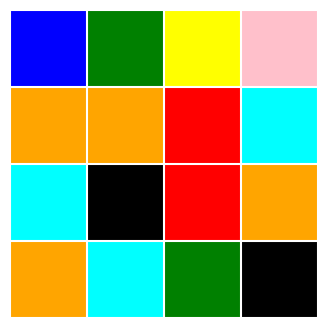

In [7]:
in_grid.plot()

The `plot` method also supports returning the base64-encoded string of the image directly

In [8]:
print(f"Base64 string: '{in_grid.plot(to_base64=True)[:20]}...'")

Base64 string: 'b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01H'...'


ArcGrids support equality checks, making it easy to test predicted grids

In [6]:
#| exporti
@patch
def __eq__(self: ArcGrid, other: ArcGrid) -> bool:
    return np.array_equal(self.data, other.data)

In [10]:
assert in_grid != ArcGrid(np.ones((3,3), dtype=int))
assert in_grid == ArcGrid(in_arr)

In [7]:
#| export
class ArcPair:
    "A pair of ARC grids, typically [input, output]. Can also be used for [output, prediction]"
    def __init__(self,
                 input_grid: ArcGrid|np.ndarray,  # Input grid
                 output_grid: ArcGrid|np.ndarray,  # Output grid
                ):
        self.input = input_grid if isinstance(input_grid, ArcGrid) else ArcGrid(input_grid)
        self.output = output_grid if isinstance(output_grid, ArcGrid) else ArcGrid(output_grid)

    def __str__(self):
        return f"ArcPair(input_shape={self.input.data.shape}, output_shape={self.output.data.shape})"
    __repr__ = __str__

    def __iter__(self):
        yield self.input
        yield self.output

    def __getitem__(self, key: Union[int, str]) -> ArcGrid:
        if isinstance(key, int):
            if key == 0: return self.input
            elif key == 1: return self.output
            else: raise IndexError("Index out of range. Only indices 0 and 1 are valid.")
        elif isinstance(key, str):
            if key == 'input': return self.input
            elif key == 'output': return self.output
            else: raise KeyError("Key must be either 'input' or 'output'.")
        else:
            raise TypeError("Key must be an integer (0 or 1) or string ('input' or 'output')")

    def __len__(self):
        return 2
        
    def plot(self,
            titles: List[str] = ['Input', 'Output'],
            same_scale: bool = True,
            fig: Optional[plt.Figure] = None,
            subplot_spec: Optional[GridSpec] = None,
            to_base64: bool = False,
            **kwargs) -> Union[None, Tuple[plt.Figure, List[plt.Axes]], str]:
        """Plot the input-output pair side by side"""
        if same_scale:
            max_width = max(self.input.shape[1], self.output.shape[1])
            max_height = max(self.input.shape[0], self.output.shape[0])
        else:
            max_width = max_height = None
    
        # Create figure or get subplot region
        if fig is None:
            fig = plt.figure(figsize=(8, 4))  # Fixed size for pairs
            # fig.patch.set_facecolor('#F0F0F0')
            fig.patch.set_alpha(0.0)
            gs = GridSpec(1, 2, figure=fig, wspace=0.3)
        else:
            gs = GridSpecFromSubplotSpec(1, 2, subplot_spec=subplot_spec, wspace=0.3)
    
        # Create axes and plot grids
        axes = []
        for i, (grid, title) in enumerate(zip([self.input, self.output], titles)):
            ax = fig.add_subplot(gs[0, i])
            grid.plot(ax=ax, title=title, max_width=max_width, max_height=max_height)
            axes.append(ax)
    
        # Add separator if this is a standalone plot
        if subplot_spec is None:
            self._create_separator(fig, axes[0].get_position(), axes[1].get_position())
            if to_base64:
                buffer = io.BytesIO()
                fig.savefig(buffer, format='png', bbox_inches='tight',
                           # facecolor='#F0F0F0', transparent=False,
                            **kwargs)
                plt.close(fig)
                buffer.seek(0)
                image_bytes = buffer.getvalue()
                buffer.close()
                return image_bytes  #base64.b64encode(image_bytes).decode()
            else:
                plt.show()
                return None
    
        return fig, axes

    @staticmethod
    def _create_separator(fig: plt.Figure, bbox1: Bbox, bbox2: Bbox) -> None:
        """Create a separator line between two subplots"""
        middle_x = (bbox1.x1 + bbox2.x0) / 2
        line = plt.Line2D([middle_x, middle_x], [0.2, 0.8],
                         transform=fig.transFigure,
                         color='black',
                         linewidth=1)
        fig.add_artist(line)

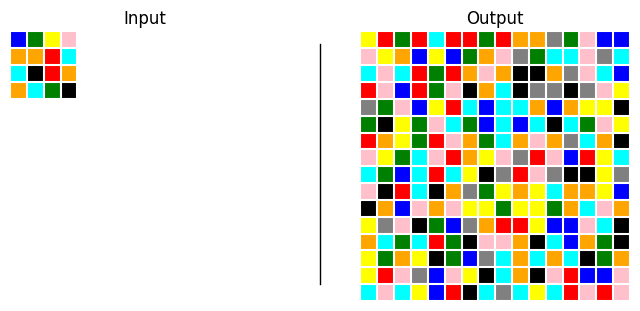

In [12]:
out_arr = np.random.randint(0, 9, (16,16))
pair = ArcPair(in_grid, ArcGrid(out_arr))
pair.plot()

The output grids in ARC tasks are often a different size to the input grids. When plotting pairs of grids, we can specify whether we want the grids to be on the same scale (i.e. one cell is equal size in both plots) or whether to rescale each grid to fill its half of the plot.

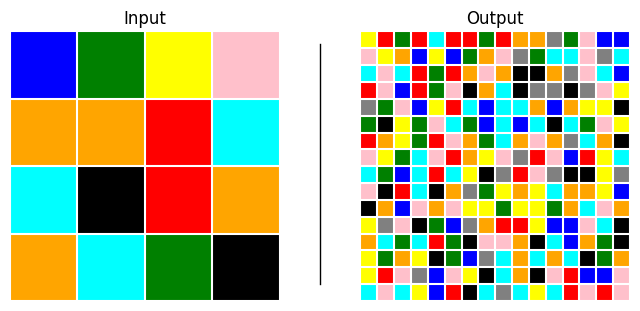

In [13]:
pair.plot(same_scale=False)

In [8]:
#| export
class ArcTask:
    "An ARC task"
    def __init__(self,
                 task_id: str,  # 8-digit task id
                 split: str = 'train',  # ARC public dataset split ('train' or 'eval')
                 data_dir: str|Path|None = None  # Path to ARC data directory (defaults to `'/path/to/arcsolver/arc_data/data'`)
                ):
        if split not in ['train', 'eval']:
            raise ValueError("`split` must be either 'train' or 'eval'")
        if data_dir is None:
            file = Path(__file__).resolve()
            data_split = 'training' if split == 'train' else 'evaluation'
            data_dir = file.parent.parent / f"arc_data/data/{data_split}"
        
        self.task_id, self.split, self.data_dir = task_id, split, Path(data_dir)
        self.train, self.test = self._load_data()

    def _load_data(self):
        with open(self.data_dir / f"{self.task_id}.json", 'r') as f:
            task_data = json.load(f)
        
        return ([ArcPair(np.array(example['input']), np.array(example['output']))
                 for example in task_data[split]]
                for split in ('train', 'test'))
    
    def __str__(self) -> str:
        return (f"ArcTask(id='{self.task_id}', "
                f"train_examples={len(self.train)}, "
                f"test_examples={len(self.test)})")
    __repr__ = __str__
    
    def plot(self,
             same_scale: bool = True,
             to_base64: bool = False,
             **kwargs) -> Union[None, str]:
        """Plot all training examples in the task"""
        n_examples = len(self.train)
    
        if n_examples == 0:
            print("No training examples available")
            return None
    
        # Fixed width, height scales with number of examples
        fig_width = 8  # Fixed width
        fig_height = 4 * n_examples  # Each example gets fixed height
    
        # Create figure and grid of subplots
        fig = plt.figure(figsize=(fig_width, fig_height))
        # fig.suptitle(f'Task {self.task_id} - Training Examples', y=0.98)
        # fig.patch.set_facecolor('#F0F0F0')
        fig.patch.set_alpha(0.0)
        
        # Create vertical stack of subplots
        gs = GridSpec(n_examples, 1, figure=fig, hspace=0.15)
    
        # Plot each training example
        for i, pair in enumerate(self.train):
            titles = [f'Example {i+1} Input', f'Example {i+1} Output']
            pair.plot(titles=titles, same_scale=same_scale,
                     fig=fig, subplot_spec=gs[i])
    
        if to_base64:
            buffer = io.BytesIO()
            fig.savefig(buffer, format='png', bbox_inches='tight',
                       # facecolor='#F0F0F0', transparent=False, 
                        **kwargs)
            plt.close(fig)
            buffer.seek(0)
            image_bytes = buffer.getvalue()
            buffer.close()
            return image_bytes  # base64.b64encode(image_bytes).decode()
        else:
            plt.show()
            return None

In [43]:
t = [f.split('.')[0] for f in os.listdir('../arc_data/data/training')][1]
task = ArcTask(t); task

ArcTask(id='c8cbb738', train_examples=3, test_examples=1)

An `ArcTask` stores the training and test examples, each as a list of `ArcPair` objects.

In [44]:
task.train

[ArcPair(input_shape=(12, 11), output_shape=(5, 5)),
 ArcPair(input_shape=(10, 8), output_shape=(3, 3)),
 ArcPair(input_shape=(12, 14), output_shape=(5, 5))]

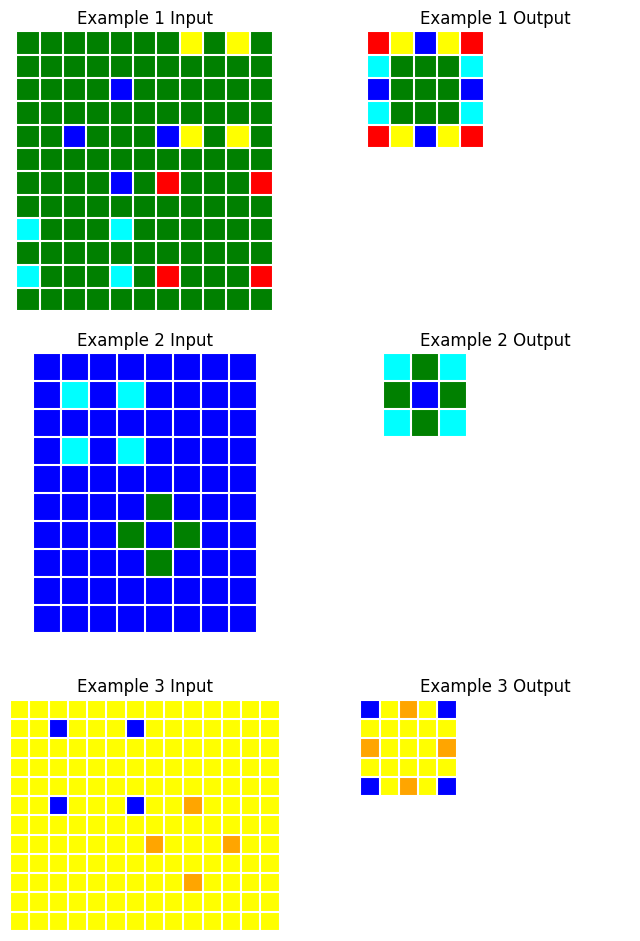

In [45]:
task.plot()

Again, we can choose whether to rescale the plots

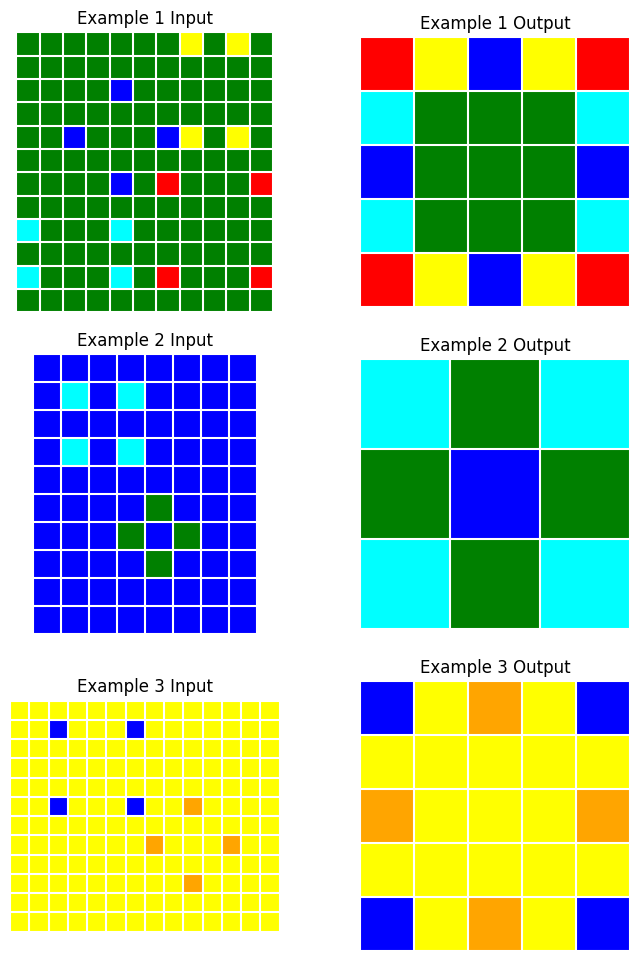

In [46]:
task.plot(same_scale=False)

In [10]:
#| export
#| eval: false
# Let's store the training and eval test ids so they can be easily used elsewhere
train_tasks = [f.split('.json')[0] for f in os.listdir(Path(__file__).resolve().parent.parent / "arc_data/data/training")]
eval_tasks = [f.split('.json')[0] for f in os.listdir(Path(__file__).resolve().parent.parent / "arc_data/data/evaluation")]

In [11]:
#| hide
import nbdev; nbdev.nbdev_export()